In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, ElasticNet, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

# Data Preprocessing

In [2]:
# load the data
bike_share_hour_df = pd.read_csv('/Users/brianmiller/Desktop/ebike_usage_regression/bike_share_hour.csv')


### Data Preparation

In [3]:
## Look at the dataset, and convert the columns that are categorical to a pandas “category” type ##
bike_share_hour_df['dteday'] = bike_share_hour_df['dteday'].astype('category')
bike_share_hour_df['season'] = bike_share_hour_df['season'].astype('category')
bike_share_hour_df['yr'] = bike_share_hour_df['yr'].astype('category')
bike_share_hour_df['mnth'] = bike_share_hour_df['mnth'].astype('category')
bike_share_hour_df['hr'] = bike_share_hour_df['hr'].astype('category')
bike_share_hour_df['holiday'] = bike_share_hour_df['holiday'].astype('category')
bike_share_hour_df['weekday'] = bike_share_hour_df['weekday'].astype('category')
bike_share_hour_df['workingday'] = bike_share_hour_df['workingday'].astype('category')
bike_share_hour_df['weathersit'] = bike_share_hour_df['weathersit'].astype('category')

print(bike_share_hour_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   instant     17379 non-null  int64   
 1   dteday      17379 non-null  category
 2   season      17379 non-null  category
 3   yr          17379 non-null  category
 4   mnth        17379 non-null  category
 5   hr          17379 non-null  category
 6   holiday     17379 non-null  category
 7   weekday     17379 non-null  category
 8   workingday  17379 non-null  category
 9   weathersit  17379 non-null  category
 10  temp        17379 non-null  float64 
 11  atemp       17379 non-null  float64 
 12  hum         17379 non-null  float64 
 13  windspeed   17379 non-null  float64 
 14  casual      17379 non-null  int64   
 15  registered  17379 non-null  int64   
 16  cnt         17379 non-null  int64   
dtypes: category(9), float64(4), int64(4)
memory usage: 1.3 MB
None


### NULL value check

In [4]:
## Look for non-null values in the dataset ##
print(bike_share_hour_df.isna().sum())

print("\n There were no missing values")

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

 There were no missing values


### Drop Unwanted Variables

In [5]:
# drop variables that are not useful
bike_share_hour_df.drop(["casual", "registered", "dteday", "instant", "atemp"], inplace=True, axis=1)

# explanation of variables dropped:
# casual and registered: These variables are dependant on the outcome variable, so they are not that useful. They are.. of the riders
# counted, how many are registered uses, and how many are not.
#
# dteday: the day of the month, while this could be useful from a time series approach, it's not that useful for my regression approach.
# There are only 2 years worth of data, with season and month columns to give us the aproximate time of year.
#
# instant: this is just integers 1-nrow, essentially it's just a copy of the index
#
# atemp: is the same variable as temp (> 0.9 R^2)

bike_share_hour_df

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0000,16
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0000,40
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0000,32
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0000,13
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,1,12,19,0,1,1,2,0.26,0.60,0.1642,119
17375,1,1,12,20,0,1,1,2,0.26,0.60,0.1642,89
17376,1,1,12,21,0,1,1,1,0.26,0.60,0.1642,90
17377,1,1,12,22,0,1,1,1,0.26,0.56,0.1343,61


# Exploratory Data Analysis  

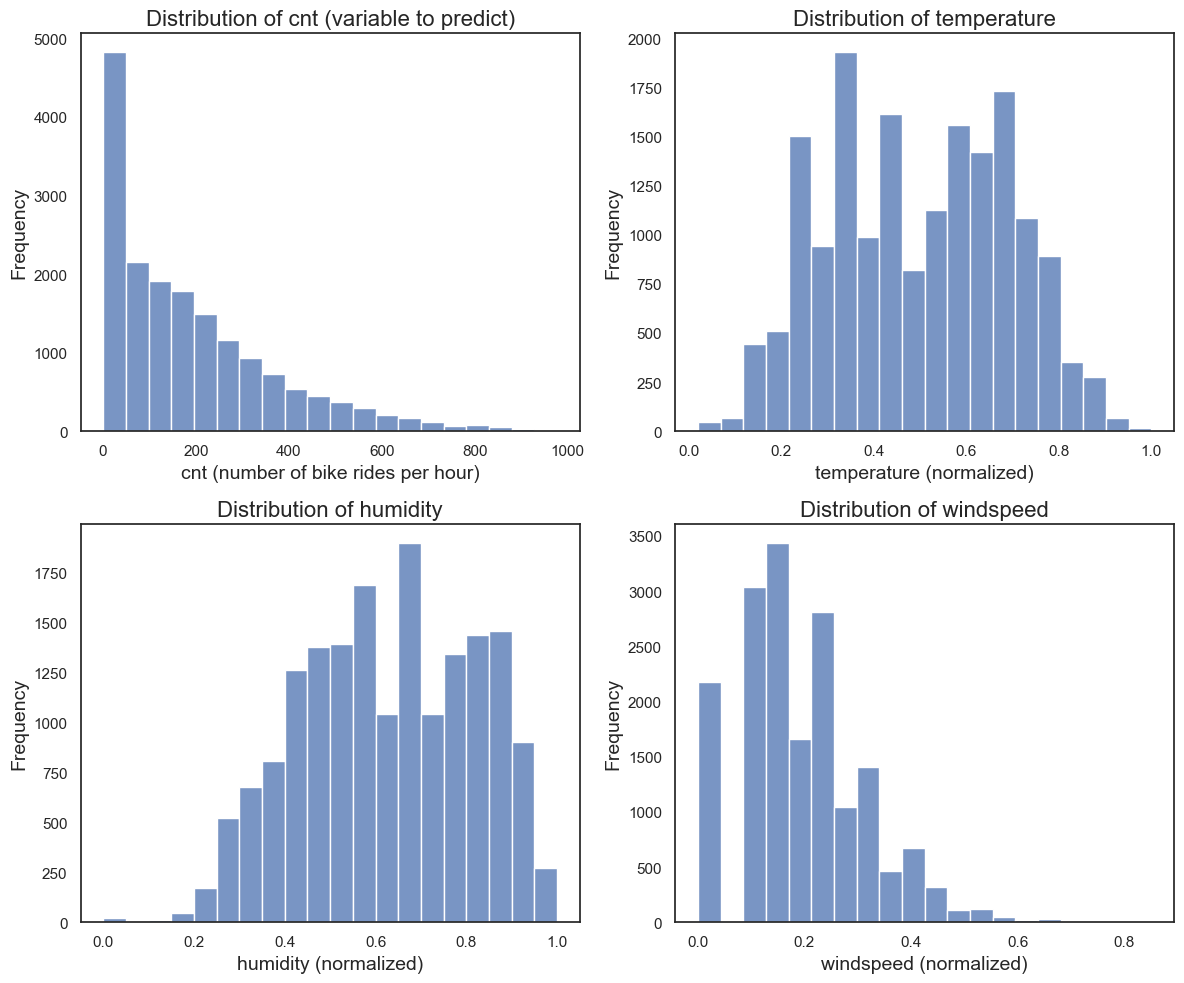

In [6]:
# Suppressing warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Set the Seaborn style to 'white' for a clean background
    sns.set(style="white")

    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Histogram for 'cnt'
    sns.histplot(bike_share_hour_df['cnt'], bins=20, palette="muted", kde=False, ax=axs[0, 0])
    axs[0, 0].set_xlabel('cnt (number of bike rides per hour)', fontsize=14)
    axs[0, 0].set_ylabel('Frequency', fontsize=14)
    axs[0, 0].set_title('Distribution of cnt (variable to predict)', fontsize=16)

    # Histogram for 'temp'
    sns.histplot(bike_share_hour_df['temp'], bins=20, palette="muted", kde=False, ax=axs[0, 1])
    axs[0, 1].set_xlabel('temperature (normalized)', fontsize=14)
    axs[0, 1].set_ylabel('Frequency', fontsize=14)
    axs[0, 1].set_title('Distribution of temperature', fontsize=16)

    # Histogram for 'hum'
    sns.histplot(bike_share_hour_df['hum'], bins=20, palette="muted", kde=False, ax=axs[1, 0])
    axs[1, 0].set_xlabel('humidity (normalized)', fontsize=14)
    axs[1, 0].set_ylabel('Frequency', fontsize=14)
    axs[1, 0].set_title('Distribution of humidity', fontsize=16)

    # Histogram for 'windspeed'
    sns.histplot(bike_share_hour_df['windspeed'], bins=20, palette="muted", kde=False, ax=axs[1, 1])
    axs[1, 1].set_xlabel('windspeed (normalized)', fontsize=14)
    axs[1, 1].set_ylabel('Frequency', fontsize=14)
    axs[1, 1].set_title('Distribution of windspeed', fontsize=16)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()


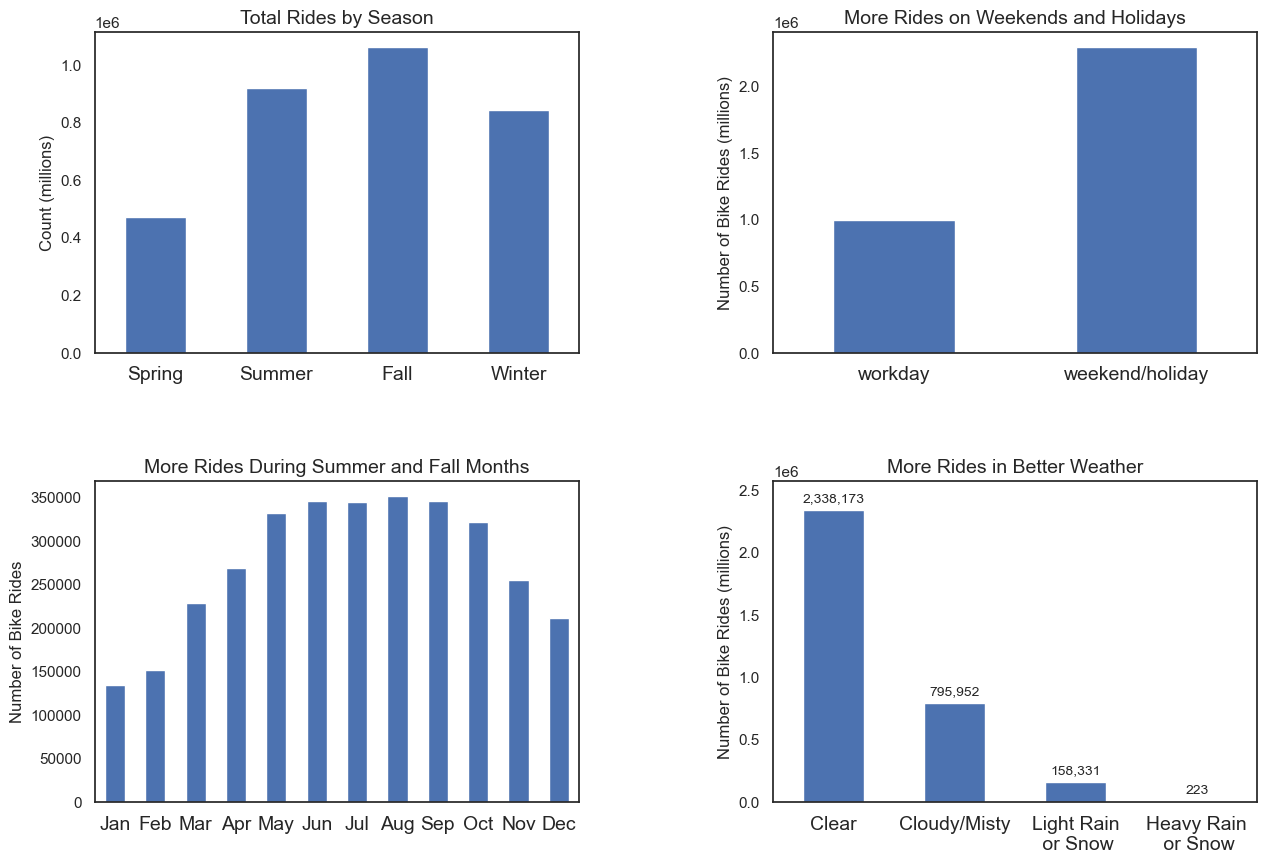

Explanation of Weather Situations
1 (Clear): Clear, Few clouds, Partly cloudy, Partly cloud
2 (Cloudy/Misty): Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3 (Light Rain/Snow): Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4 (Heavy Rain/Snow): Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

weathersit
1    2338173
2     795952
3     158331
4        223
Name: cnt, dtype: int64

It looks like there were only 223 brave souls that decided to rent a bike when the weather was horrible.


In [36]:
# Creating a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Adjust the space between the plots
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Total Rides by Season
season_cnt = bike_share_hour_df.groupby('season')['cnt'].sum()
season_cnt.plot(kind='bar', ax=axs[0, 0])
axs[0, 0].set_xticklabels(['Spring', 'Summer', 'Fall', 'Winter'], rotation=0, fontsize=14)
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Count (millions)', fontsize=12)
axs[0, 0].set_title('Total Rides by Season', fontsize=14)

# Total Bike Rides by Day Type
working_cnt = bike_share_hour_df.groupby('workingday')['cnt'].sum()
working_cnt.plot(kind='bar', ax=axs[0, 1])
axs[0, 1].set_xticklabels(['workday', 'weekend/holiday'], rotation=0, fontsize=14)
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('Number of Bike Rides (millions)', fontsize=12)
axs[0, 1].set_title('More Rides on Weekends and Holidays', fontsize=14)

# Total Bike Rides by Month
mnth_cnt = bike_share_hour_df.groupby('mnth')['cnt'].sum()
mnth_cnt.plot(kind='bar', ax=axs[1, 0])
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axs[1, 0].set_xticklabels(months, rotation=0, fontsize=14)
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('Number of Bike Rides', fontsize=12)
axs[1, 0].set_title('More Rides During Summer and Fall Months', fontsize=14)

# Total Bike Rides by Weather Situation
weather_cnt = bike_share_hour_df.groupby('weathersit')['cnt'].sum()
bars = weather_cnt.plot(kind='bar', ax=axs[1, 1])
axs[1, 1].set_xticklabels(["Clear", "Cloudy/Misty", "Light Rain\n or Snow", "Heavy Rain\n or Snow"], rotation=0, fontsize=14)
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('Number of Bike Rides (millions)', fontsize=12)
axs[1, 1].set_title('More Rides in Better Weather', fontsize=14)

# Find the maximum value for setting the y-axis limit
max_height = max(weather_cnt) * 1.1  # 10% more than the tallest bar
axs[1, 1].set_ylim(0, max_height)

# Annotate the data values above each bar with commas
for bar in bars.patches:
    axs[1, 1].annotate("{:,}".format(int(bar.get_height())), 
                       (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                       size=10, xytext=(0, 8),
                       textcoords='offset points')

plt.show()


print("Explanation of Weather Situations")
print('1 (Clear): Clear, Few clouds, Partly cloudy, Partly cloud')
print('2 (Cloudy/Misty): Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist')
print('3 (Light Rain/Snow): Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds')
print('4 (Heavy Rain/Snow): Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog\n')
print(weather_cnt)
print("\nIt looks like there were only 223 brave souls that decided to rent a bike when the weather was horrible.")

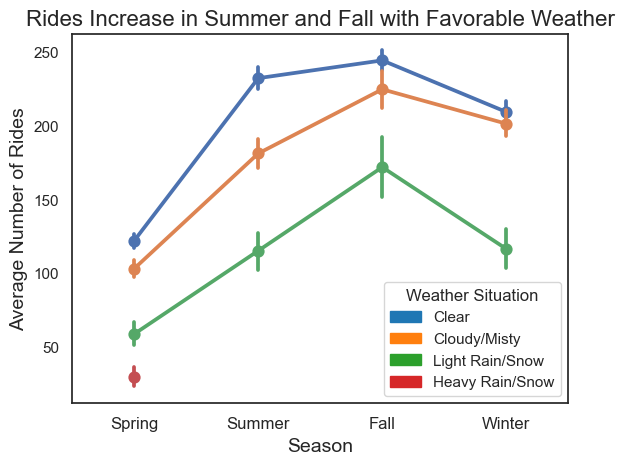

Explanation of Weather Situations
1 (Clear): Clear, Few clouds, Partly cloudy, Partly cloud
2 (Cloudy/Misty): Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3 (Light Rain/Snow): Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4 (Heavy Rain/Snow): Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

As the weather gets worse there are less rides. From good biking weather (1) to ok weather (2) does not stop a lot of people. But riding in bad (3) or terrible (4) biking weather seems to really dissuade riders. 

NOTE:
There are only three datapoints for rides during the worst weather situation metric (4). 
The three cnt data points are 23, 36, 164 
The interesting 164 data point is what is causing the variance to be so large.


In [38]:
# Bike Ride Counts by Weather Situation and Season
sns.pointplot(x='season', y='cnt', hue='weathersit', data=bike_share_hour_df[~((bike_share_hour_df['weathersit'] == 4) & (bike_share_hour_df['cnt'] == 164))])

# Set the axis labels and title with increased font sizes
plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Number of Rides', fontsize=14)
plt.title('Rides Increase in Summer and Fall with Favorable Weather', fontsize=16)

# Manually set the x labels with increased font size
season_labels = ['Spring', 'Summer', 'Fall', 'Winter']
plt.xticks(range(4), season_labels, fontsize=12)

# Create custom legend handles with colored bullets
legend_handles = [
    mpatches.Patch(color='tab:blue', label='Clear'),
    mpatches.Patch(color='tab:orange', label='Cloudy/Misty'),
    mpatches.Patch(color='tab:green', label='Light Rain/Snow'),
    mpatches.Patch(color='tab:red', label='Heavy Rain/Snow')
]

# Increase the font size of the legend title
plt.legend(title='Weather Situation', handles=legend_handles, title_fontsize=12)

plt.show()


print("Explanation of Weather Situations")
print('1 (Clear): Clear, Few clouds, Partly cloudy, Partly cloud')
print('2 (Cloudy/Misty): Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist')
print('3 (Light Rain/Snow): Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds')
print('4 (Heavy Rain/Snow): Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog\n')
print("As the weather gets worse there are less rides. From good biking weather (1) to ok weather (2) does not stop a lot of people. But riding in bad (3) or terrible (4) biking weather seems to really dissuade riders. ")
print("\nNOTE:\nThere are only three datapoints for rides during the worst weather situation metric (4). \nThe three cnt data points are 23, 36, 164 \nThe interesting 164 data point is what is causing the variance to be so large.")


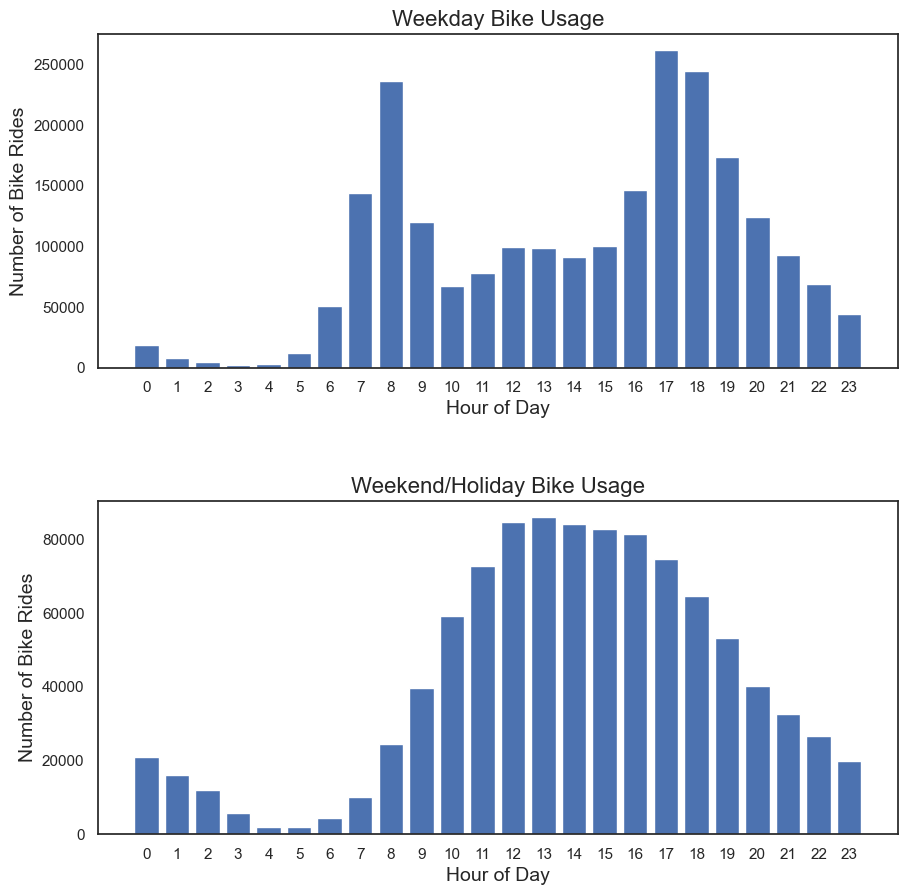

For the weekend and holiday days, we no longer see the 9-5 commuting trend. We see peak usage around 12pm-4pm, and usage tail off on either side of that window.


In [12]:
# Bike Ride Count by hour, and type of day

# group the dataframe by hour and workingday
hour_cnt_workingday = bike_share_hour_df.groupby(['hr', 'workingday'])['cnt'].sum()

# pivot the dataframe to create separate columns for workingday=1 and workingday=0
hour_cnt_workingday = hour_cnt_workingday.unstack(level=1)

# create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# create a bar plot for workingday=1 in the first subplot
axs[0].bar(hour_cnt_workingday.index, hour_cnt_workingday[1])
axs[0].set_xlabel('Hour of Day', fontsize=14)
axs[0].set_ylabel('Number of Bike Rides', fontsize=14)
axs[0].set_title('Weekday Bike Usage', fontsize=16)
axs[0].set_xticks(range(24))  # set x-axis ticks to integers 0-23

# create a bar plot for workingday=0 in the second subplot
axs[1].bar(hour_cnt_workingday.index, hour_cnt_workingday[0])
axs[1].set_xlabel('Hour of Day', fontsize=14)
axs[1].set_ylabel('Number of Bike Rides', fontsize=14)
axs[1].set_title('Weekend/Holiday Bike Usage', fontsize=16)
axs[1].set_xticks(range(24))  # set x-axis ticks to integers 0-23

# adjust the spacing between subplots
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)

# display the plots
plt.show()

print("For the weekend and holiday days, we no longer see the 9-5 commuting trend. We see peak usage around 12pm-4pm, and usage tail off on either side of that window.")


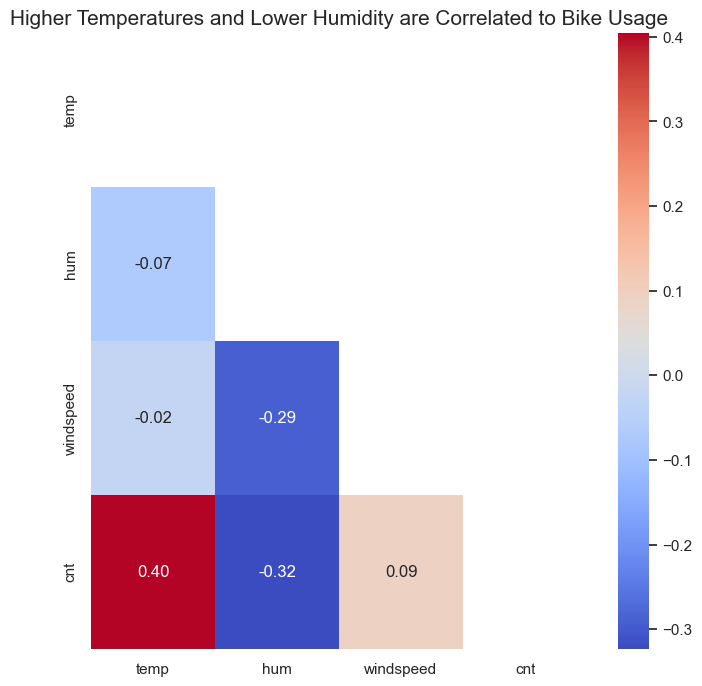

In [42]:
# select only the numeric features
categorical_columns = bike_share_hour_df.select_dtypes(include=['category']).columns.tolist()
bike_share_hour_numeric_df = bike_share_hour_df.drop(categorical_columns, axis=1)

# create a correlation matrix
corr_matrix = bike_share_hour_numeric_df.corr()

# Create a mask to display only one half of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(8,8))  # create a figure and axis object

# Pass the mask to the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, ax=ax, fmt=".2f") 

plt.title('Higher Temperatures and Lower Humidity are Correlated to Bike Usage', fontsize=15)
plt.show()  # display the plot



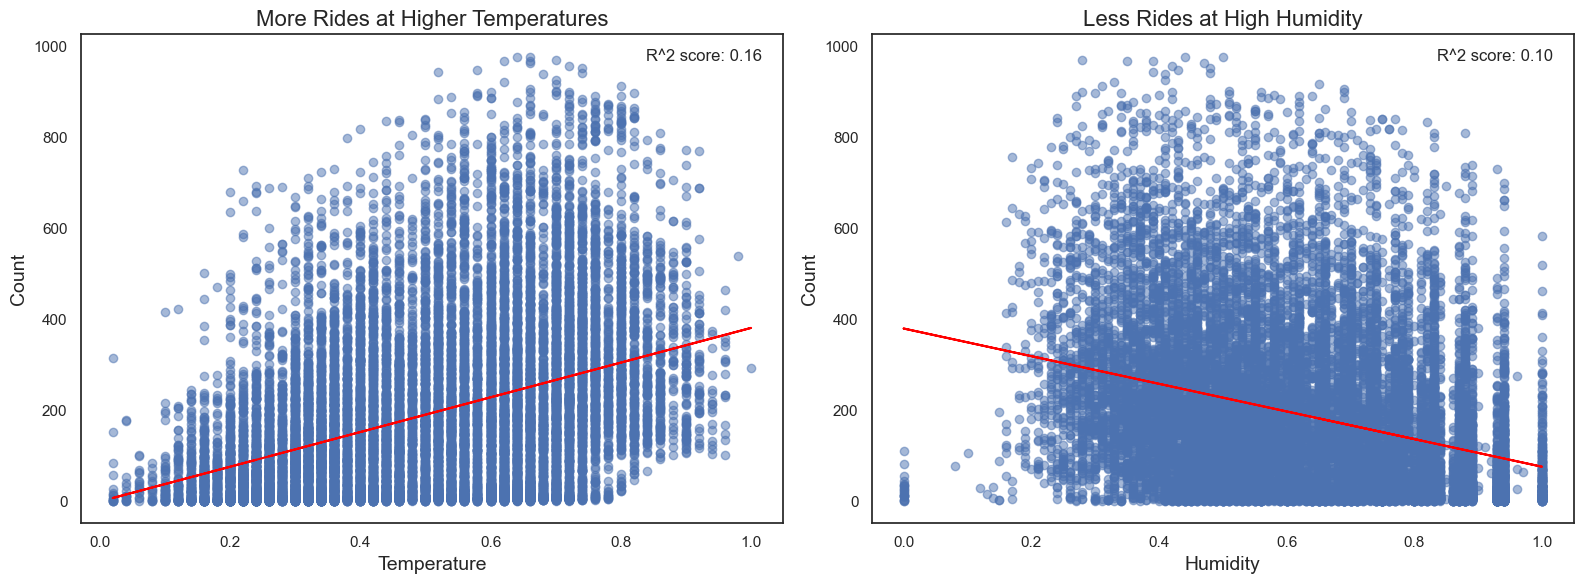

In [47]:
# Define a function to create scatter plot, add trendline and print R^2 score
def plot_with_trendline(ax, x, y, xlabel, ylabel, title):
    # Scatter plot on the provided axes
    ax.scatter(x, y, alpha=0.5)
    ax.set_xlabel(xlabel, fontsize=14)  # Increase font size for x label
    ax.set_ylabel(ylabel, fontsize=14)  # Increase font size for y label
    ax.set_title(title, fontsize=16)  # Increase title font size

    # Add trendline
    coefficients = np.polyfit(x, y, 1)
    poly = np.poly1d(coefficients)
    ax.plot(x, poly(x), color='red')

    # Calculate and print R^2 score
    y_pred = poly(x)
    r2 = r2_score(y, y_pred)
    ax.text(0.97, 0.97, f'R^2 score: {r2:.2f}', ha='right', va='top', transform=ax.transAxes, fontsize=12)  # Include R^2 score in the plot

# Create figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Call the function for 'temp' on the first subplot (left side)
plot_with_trendline(axs[0], bike_share_hour_df['temp'], bike_share_hour_df['cnt'], 'Temperature', 'Count', 'More Rides at Higher Temperatures')

# Call the function for 'hum' on the second subplot (right side)
plot_with_trendline(axs[1], bike_share_hour_df['hum'], bike_share_hour_df['cnt'], 'Humidity', 'Count', 'Less Rides at High Humidity')

# Adjust the layout so that titles and labels do not overlap
plt.tight_layout()

plt.show()


# Scale Numerical Variables and Encode Categorical Variables
To prepare the data, lets do the following:
 - StandardScale the numeric variables
 - One-hot encode the categorical variables

In [48]:
# scale the numeric variables, one-hot encode the categorical variables

### scale the numeric features
scaler = StandardScaler()
bike_share_hour_numeric_scaled = scaler.fit_transform(bike_share_hour_numeric_df)
numeric_features_names = bike_share_hour_numeric_df.columns.to_list()

# create a new dataframe with the scaled features
bike_share_hour_numeric_scaled_df = pd.DataFrame(bike_share_hour_numeric_scaled, columns=numeric_features_names)

### one-hot encode the categorical variables
categorical_columns = bike_share_hour_df.select_dtypes(include=['category']).columns.tolist()

# use get_dummies to one-hot-encode categorical columns
one_hot_encoded = pd.get_dummies(bike_share_hour_df[categorical_columns], prefix=categorical_columns)

### combine the numeric and categorical variables
bike_share_hour_df_scaled_hot = pd.concat([bike_share_hour_numeric_scaled_df, one_hot_encoded], axis=1)

bike_share_hour_df_scaled_hot.head()

,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,yr_0,yr_1,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,holiday_0,holiday_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,-1.334648,0.947372,-1.553889,-0.956339,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0
1,-1.438516,0.895539,-1.553889,-0.824022,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0
2,-1.438516,0.895539,-1.553889,-0.868128,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0
3,-1.334648,0.636370,-1.553889,-0.972879,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0
4,-1.334648,0.636370,-1.553889,-1.039037,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0


In [49]:
bike_share_hour_df_scaled_hot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 61 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp          17379 non-null  float64
 1   hum           17379 non-null  float64
 2   windspeed     17379 non-null  float64
 3   cnt           17379 non-null  float64
 4   season_1      17379 non-null  uint8  
 5   season_2      17379 non-null  uint8  
 6   season_3      17379 non-null  uint8  
 7   season_4      17379 non-null  uint8  
 8   yr_0          17379 non-null  uint8  
 9   yr_1          17379 non-null  uint8  
 10  mnth_1        17379 non-null  uint8  
 11  mnth_2        17379 non-null  uint8  
 12  mnth_3        17379 non-null  uint8  
 13  mnth_4        17379 non-null  uint8  
 14  mnth_5        17379 non-null  uint8  
 15  mnth_6        17379 non-null  uint8  
 16  mnth_7        17379 non-null  uint8  
 17  mnth_8        17379 non-null  uint8  
 18  mnth_9        17379 non-nu

# Data Splitting

In [50]:
# split the data, 33%

# split the dataframe into features and target
predictors = bike_share_hour_df_scaled_hot.drop('cnt', axis=1)
target = bike_share_hour_df_scaled_hot['cnt']

# split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size=0.33, random_state=42)

# print the shapes of the training and testing sets
print('Training set shape:', x_train.shape, y_train.shape)
print('Testing set shape:', x_test.shape, y_test.shape)


Training set shape: (11643, 60) (11643,)
Testing set shape: (5736, 60) (5736,)


# Model Building and Evaluation

### Model Building

In [51]:
# Linear Model
lm_model = LinearRegression()
lm_model.fit(x_train, y_train)

# Decision Tree
dt_regressor = DecisionTreeRegressor(random_state=0)
dt_regressor.fit(x_train, y_train)

# Random Forest
rf_regressor = RandomForestRegressor(random_state=0, n_estimators=30)
rf_regressor.fit(x_train, y_train)

# SGD
sgd_regressor = SGDRegressor(max_iter=1000, tol=1e-3, random_state=0)
sgd_regressor.fit(x_train, y_train)

# Ridge
ridge_regressor = Ridge(alpha=0.5, random_state=0)
ridge_regressor.fit(x_train, y_train)

# Bagging
bagging_regressor = BaggingRegressor(random_state=0)
bagging_regressor.fit(x_train, y_train)

print("")

### Compare model performance using 6-fold Cross Validation

In [54]:
## Take the models and implement cross-validation on them ##

# Use cross-validation to calculate MSE scores, and r2 scores
ridge_mse_scores = -cross_val_score(ridge_regressor, x_train, y_train, cv=6, scoring='neg_mean_squared_error')
ridge_r2_scores = cross_val_score(ridge_regressor, x_train, y_train, cv=6, scoring='r2')
sgd_mse_scores = -cross_val_score(sgd_regressor, x_train, y_train, cv=6, scoring='neg_mean_squared_error')
sgd_r2_scores = cross_val_score(sgd_regressor, x_train, y_train, cv=6, scoring='r2')
lm_mse_scores = -cross_val_score(lm_model, x_train, y_train, cv=6, scoring='neg_mean_squared_error')
lm_r2_scores = cross_val_score(lm_model, x_train, y_train, cv=6, scoring='r2')
rf_mse_scores = -cross_val_score(rf_regressor, x_train, y_train, cv=6, scoring='neg_mean_squared_error')
rf_r2_scores = cross_val_score(rf_regressor, x_train, y_train, cv=6, scoring='r2')
bagging_mse_scores = -cross_val_score(bagging_regressor, x_train, y_train, cv=6, scoring='neg_mean_squared_error')
bagging_r2_scores = cross_val_score(bagging_regressor, x_train, y_train, cv=6, scoring='r2')
dt_mse_scores = -cross_val_score(dt_regressor, x_train, y_train, cv=6, scoring='neg_mean_squared_error')
dt_r2_scores = cross_val_score(dt_regressor, x_train, y_train, cv=6, scoring='r2')

print("Model Performance:")

print("\nLinear Regressor")
print("Xval R^2  ", np.mean(lm_r2_scores))
print("Xval RMSE ", np.sqrt(np.mean(lm_mse_scores)))

print("\nDecision TreeRegressor")
print("Xval R^2  ", np.mean(dt_r2_scores))
print("Xval RMSE ", np.sqrt(np.mean(dt_mse_scores)))

print("\nSGD Regressor")
print("Xval R^2  ", np.mean(sgd_r2_scores))
print("Xval RMSE ", np.sqrt(np.mean(sgd_mse_scores)))

print("\nRidge Regressor")
print("Xval R^2  ", np.mean(ridge_r2_scores))
print("Xval RMSE ", np.sqrt(np.mean(ridge_mse_scores)))

print("\nBagging Regressor")
print("Xval R^2  ", np.mean(bagging_r2_scores))
print("Xval RMSE ", np.sqrt(np.mean(bagging_mse_scores)))

print("\nRandom Forest Regressor")
print("Xval R^2  ", np.mean(rf_r2_scores))
print("Xval RMSE ", np.sqrt(np.mean(rf_mse_scores)))

print("\nRandom Forest Regressor worked the best..")


Model Performance:

Linear Regressor
Xval R^2   0.6852067341392635
Xval RMSE  0.5646628915324813

Decision TreeRegressor
Xval R^2   0.8349749816219919
Xval RMSE  0.4088635675960901

SGD Regressor
Xval R^2   0.6825192259800456
Xval RMSE  0.5671338383420537

Ridge Regressor
Xval R^2   0.6852513164006839
Xval RMSE  0.5646245191082286

Bagging Regressor
Xval R^2   0.9043644193631627
Xval RMSE  0.31122354266189417

Random Forest Regressor
Xval R^2   0.9146153688224219
Xval RMSE  0.2939249319300158

Random Forest Regressor worked the best..


# Model Optimization (Hyperparameter Tuning)

Random Forest Regressor performed the best, lets tune it!

Param distribution:
 - Bootstrap:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;True, False
 - Max_depth:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;10-110, number of bins 11
 - Max_features:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;auto, sqrt
 - Min_samples_split:&nbsp;&nbsp;&nbsp;&nbsp;2,5,10
 - Min_samples_leaf:&nbsp;&nbsp;&nbsp;&nbsp;1,2,4
 - N_estimators:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;200 – 2000, number of bins 10  
<br>  
 - 20 combinations of the above params will be used to train the model with the training data.   
 - The model with the best R^2 will be outputted..

In [56]:
# Set up the parameter distribution
param_dist = {
    'bootstrap': [True, False],
    'max_depth': [ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': np.linspace(200, 2000, 10, dtype=int)
}

# Create a randomized search cross-validation object
random_search = RandomizedSearchCV(
    estimator=rf_regressor,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    random_state=0,
    n_jobs=7  # I have 8 cores
)

# Fit the randomized search cross-validation object to the training data
random_search.fit(x_train, y_train)

# Print the best parameters and score
print("Best Parameters: ", random_search.best_params_)


Best Parameters:  {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40, 'bootstrap': True}


In [57]:
# see what the Xval metrics are for the tuned model
rf_tuned_mse_scores = -cross_val_score(random_search.best_estimator_, x_train, y_train, cv=6, scoring='neg_mean_squared_error')
rf_tuned_r2_scores = cross_val_score(random_search.best_estimator_, x_train, y_train, cv=6, scoring='r2')

print("RandomForestRegressor (tuned with random search)")
print("Train Xval R^2  ", np.mean(rf_tuned_r2_scores))
print("Train Xval RMSE ", np.sqrt(np.mean(rf_tuned_mse_scores)))

RandomForestRegressor (tuned with random search)
Train Xval R^2   0.9170254090835693
Train Xval RMSE  0.28978735730887784


In [58]:
# finally, compare the the test set
rf_tuned_mse_scores = -cross_val_score(random_search.best_estimator_, x_test, y_test, cv=6, scoring='neg_mean_squared_error')
rf_tuned_r2_scores = cross_val_score(random_search.best_estimator_, x_test, y_test, cv=6, scoring='r2')

print("RandomForestRegressor (tuned with random search)")
print("Test Xval R^2  ", np.mean(rf_tuned_r2_scores))
print("Test Xval RMSE ", np.sqrt(np.mean(rf_tuned_mse_scores)))

RandomForestRegressor (tuned with random search)
Test Xval R^2   0.8853303580216282
Test Xval RMSE  0.33349899770253133


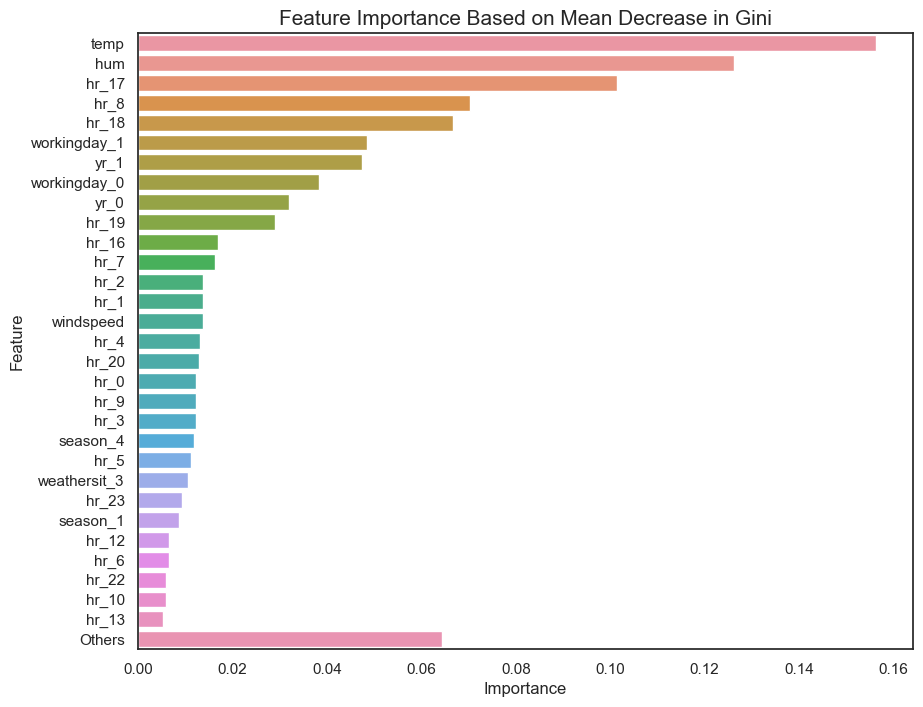

In [64]:
# Number of features you want to keep
n = 30

import pandas as pd

# Assuming you have a list or array of feature names
feature_names = x_train.columns  # Replace with your actual feature names if different

# Extract feature importances from the best estimator
feature_importances = random_search.best_estimator_.feature_importances_

# Create the importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)


# Step 1: Extract feature importances
feature_importances = random_search.best_estimator_.feature_importances_

# Sum of importances of "other" features
others_importance = importance_df['importance'][n:].sum()

# Keep only the top 'n' features
top_features = importance_df[:n]

# Add a row for the "other" features
others_row = pd.DataFrame({'feature': ['Others'], 'importance': [others_importance]})

# Concatenate top_features and others_row
final_df = pd.concat([top_features, others_row], ignore_index=True)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=final_df)
plt.title('Feature Importance Based on Mean Decrease in Gini', fontsize=15)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


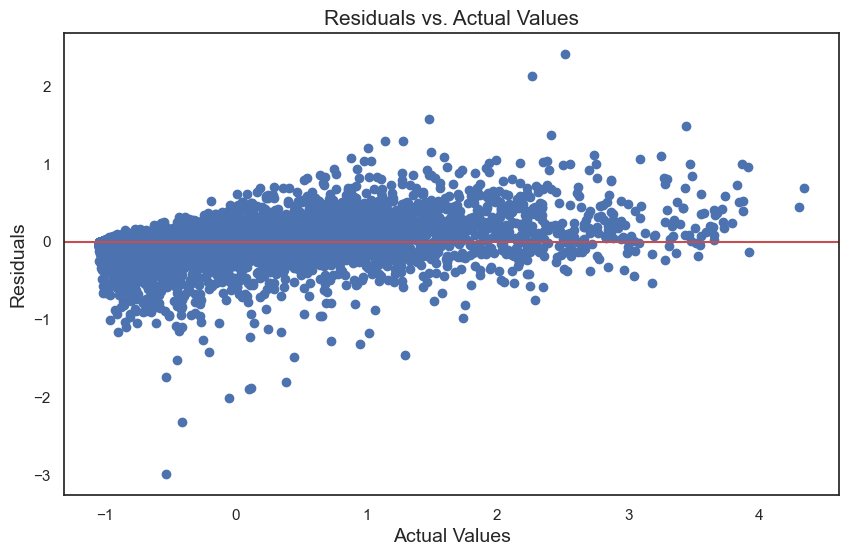

In [70]:
residuals = y_test - random_search.best_estimator_.predict(x_test)
plt.figure(figsize=(10,6))
plt.scatter(y_test, residuals)
plt.title('Residuals vs. Actual Values', fontsize=15)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


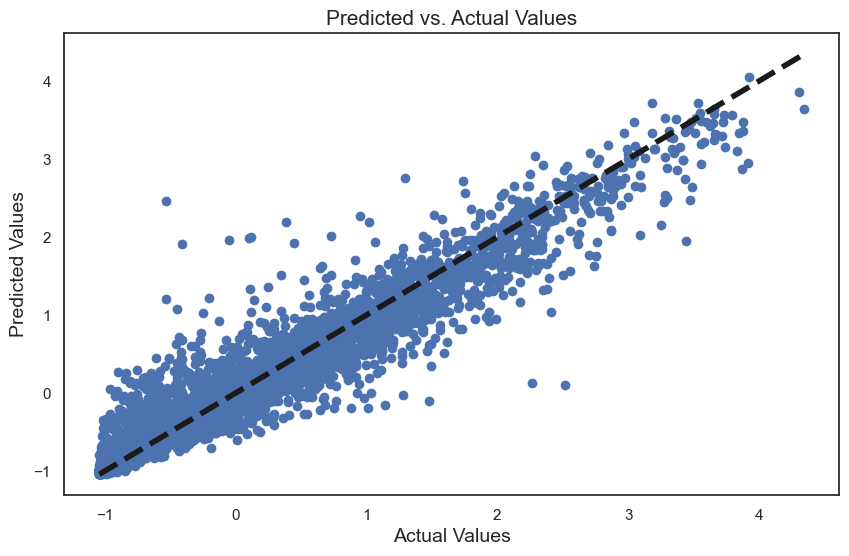

In [71]:
predicted_values = random_search.best_estimator_.predict(x_test)
plt.figure(figsize=(10,6))
plt.scatter(y_test, predicted_values)
plt.title('Predicted vs. Actual Values', fontsize=15)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()
